Illustration of the robustness to noisy vector fields

In [5]:
import sys
import pandas as pd
import numpy as np
from functions import *
from pathlib import Path

SCRIPT_DIR = Path(os.getcwd())

def VectorfieldtoDigraph_arc(VF,length,width,high,eps):
    VectorField=pd.read_csv(VF,header=None)
    VectorField=pd.DataFrame(VectorField)

    n=VectorField.shape[0]
    Digraph_mat=lil_matrix((n,n),dtype='float32')

    max_edge=0
    for xi in range(xbegin,xbegin+L,s):
        for yi in range(ybegin,ybegin+W,s):
            i=width*high*xi+high*yi
            vxi=VectorField.iloc[i,4]
            vyi=VectorField.iloc[i,5]

            if xi+s<xbegin+L:
                xj=xi+s
                yj=yi
                j=width*high*xj+high*yj
                vxj=VectorField.iloc[j,4]
                vyj=VectorField.iloc[j,5]
                arr1=np.array([vxi,vyi,0])
                arr2=np.array([vxj,vyj,0])
                if (vxi==0 and vyi==0) or (vxj==0 and vyj==0):
                    Digraph_mat[i,j]=0
                    Digraph_mat[j,i]=0
                else:
                    th=get_theta(arr1,arr2)
                    w_x=get_sgn(arr1,arr2)*th
                    if abs(abs(th)-pi)==0 or th==0 or abs(w_x)>eps:
                        Digraph_mat[i,j]=0
                        Digraph_mat[j,i]=0
                    elif w_x>0:
                        Digraph_mat[i,j]=w_x
                    else:
                        Digraph_mat[j,i]=-w_x
                    max_edge=max(max_edge,w_x)
            if yi+s<ybegin+W:
                yj=yi+s
                xj=xi
                j=width*high*xj+high*yj
                vxj=VectorField.iloc[j,4]
                vyj=VectorField.iloc[j,5]
                arr1=np.array([vxi,vyi,0])
                arr2=np.array([vxj,vyj,0])
                if (vxi==0 and vyi==0) or (vxj==0 and vyj==0):
                    Digraph_mat[i,j]=0
                    Digraph_mat[j,i]=0
                else:
                    th=get_theta(arr1,arr2)
                    w_y=get_sgn(arr1,arr2)*th
                    if abs(abs(th)-pi)==0 or th==0 or abs(w_y)>eps:
                        Digraph_mat[i,j]=0
                        Digraph_mat[j,i]=0
                    elif w_y>0:
                        Digraph_mat[i,j]=w_y
                    else:
                        Digraph_mat[j,i]=-w_y
                    max_edge=max(max_edge,w_y)

    Digraph_mat=Digraph_mat.tocoo()
    return max_edge, Digraph_mat

def compute_sqar(mat,v1,v2,v3,v4,VF,bps,min_cyc,centers,eps,latbegin,lonbegin):
    flag=0
    rel=None
    V1=np.array([VF.iloc[v1,4],VF.iloc[v1,5],VF.iloc[v1,6]])
    V2=np.array([VF.iloc[v2,4],VF.iloc[v2,5],VF.iloc[v2,6]])
    V3=np.array([VF.iloc[v3,4],VF.iloc[v3,5],VF.iloc[v3,6]])
    V4=np.array([VF.iloc[v4,4],VF.iloc[v4,5],VF.iloc[v4,6]])
    t=(get_theta1(V1,V2)+get_theta1(V2,V3)+get_theta1(V3,V4)+get_theta1(V4,V1))/(2*pi)
    if t==t:
        index=round(t)
    else:
        index=0
    if (([v1,v2,v3,v4,index] not in min_cyc)) and index!=0:
        min_cyc.append([v1,v2,v3,v4,index])
        bps.append((weight_point([v1,v2,v3,v4],VF,mat)))
        rel= [round(eps*weight_point([v1,v2,v3,v4],VF,mat)[0]+lonbegin,2),round(eps*weight_point([v1,v2,v3,v4],VF,mat)[1]+latbegin,2)]
        print(rel,index)
    return rel,index

In [6]:
def plot_vector_field_with_singularities(VF, centers):
    fig, ax = plt.subplots(figsize=(20,10), facecolor='none')
    
    x = np.linspace(min(VF.iloc[:,1]), max(VF.iloc[:,1]), int(max(VF.iloc[:,1])-min(VF.iloc[:,1]))+1)
    y = np.linspace(min(VF.iloc[:,2]), max(VF.iloc[:,2]), int(max(VF.iloc[:,2])-min(VF.iloc[:,2]))+1)
    X, Y = np.meshgrid(x, y)
    
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(len(x)):
        for j in range(len(y)):
            idx = VF[(VF.iloc[:,1]==x[i]) & (VF.iloc[:,2]==y[j])].index
            if len(idx) > 0:
                U[j,i] = VF.iloc[idx[0], 4]
                V[j,i] = VF.iloc[idx[0], 5]
    
    plt.streamplot(X, Y, U, V, color='black', linewidth=1, density=3)
    
    for p in centers:
        color = 'r' if p[1] == 1 else 'b'
        plt.plot(p[0][0], p[0][1], c=color, marker='o', markersize=8)
    
    plt.axis('off')
    plt.grid(False)
    plt.show()

In [7]:
rig='noise_0.03'
VF= SCRIPT_DIR / 'noise' /f'{rig}.csv'
VF_file=VF

VFd=pd.read_csv(VF,header=None)
ls=max(VFd.iloc[:,1])+1
ws=max(VFd.iloc[:,2])+1

In [8]:
ls=pd.read_csv(VF,header=None).iloc[:,1]
ws=pd.read_csv(VF,header=None).iloc[:,2]
all_len=pd.read_csv(VF,header=None).shape[0]

s=1
eps=1
lonbegin,latbegin=0,0

length,width,high=max(ls)+1,max(ws)+1,1
L,W=length,width
xbegin,ybegin=0,0 
max_edge,mat = VectorfieldtoDigraph_arc(VF,length,width,high,10)
mat=mat.tolil()

G=nx.from_scipy_sparse_array(mat, create_using=nx.DiGraph)
g=persHomo(G)
max_edge=3.15
g.perHom(max_edge)

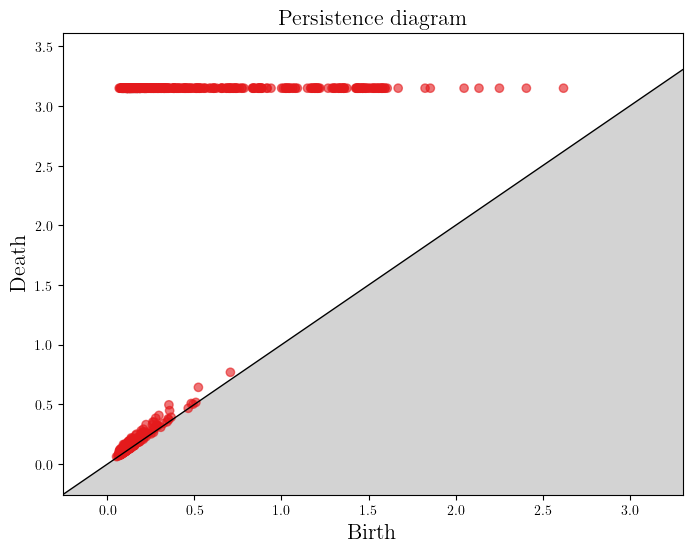

In [9]:
import gudhi as gd
pairs=np.array(g.pair)
gd.plot_persistence_diagram(pairs)
plt.gcf().set_size_inches(8, 6) 
plt.show()

In [10]:
e=[]
min_cyc=[]
bps=[]
centers=[]
pairs=np.array(g.pair)
for i in range(len(pairs)):
    if pairs[i][1]==max_edge:
        e.append(pairs[i][0])

VF=pd.read_csv(VF,header=None)
while len(e)>0:
    i1,j1,i2,j2=find_edge(e[0],xbegin,ybegin,s,L,W,width,mat)
    w=max(mat[i1*width*high+j1*high,i2*width*high+j2*high],mat[i2*width*high+j2*high,i1*width*high+j1*high])
    flag=0
    if i2-i1==s:
        i=i1
        j=j1
        v1,v2,v3,v4=i*width*high+j*high,(i+s)*width*high+j*high,(i+s)*width*high+(j+s)*high,i*width*high+(j+s)*high
        if i+s<xbegin+L and j+s<ybegin+W:
            non=find_non_edge4_rightup(i,j,s,width,mat)
            if len(non)==0:
                center=compute_sqar(mat,v1,v2,v3,v4,VF,bps,min_cyc,centers,eps,latbegin,lonbegin)
                if center[0] and center not in centers:
                    centers.append(center)
        
        v1,v2,v3,v4=i*width*high+(j-s)*high,(i+s)*width*high+(j-s)*high,(i+s)*width*high+j*high,i*width*high+j*high
        if i+s<xbegin+L and j-s>=ybegin:
            non=find_non_edge4_rightdown(i,j,s,width,mat)
            if len(non)==0:
                center=compute_sqar(mat,v1,v2,v3,v4,VF,bps,min_cyc,centers,eps,latbegin,lonbegin)
                if center[0] and center not in centers:
                    centers.append(center)

    if j2-j1==s:
        i=i1
        j=j1
        v1,v2,v3,v4=i*width*high+j*high,(i+s)*width*high+j*high,(i+s)*width*high+(j+s)*high,i*width*high+(j+s)*high
        if i+s<xbegin+L and j+s<ybegin+W:
            non=find_non_edge4_upright(i,j,s,width,mat)
            if len(non)==0:
                center=compute_sqar(mat,v1,v2,v3,v4,VF,bps,min_cyc,centers,eps,latbegin,lonbegin)
                if center[0] and center not in centers:
                    centers.append(center)

        v1,v2,v3,v4=(i-s)*width*high+j*high,i*width*high+j*high,i*width*high+(j+s)*high,(i-s)*width*high+(j+s)*high
        if i-s>=xbegin and j+s<ybegin+W:
            non=find_non_edge4_upleft(i,j,s,width,mat)
            if len(non)==0:
                center=compute_sqar(mat,v1,v2,v3,v4,VF,bps,min_cyc,centers,eps,latbegin,lonbegin)
                if center[0] and center not in centers:
                    centers.append(center)

    del(e[0])
print(len(centers))
singular_num=len(centers)

[29.49, 29.57] 1
[49.51, 29.56] 1
[49.47, 9.59] 1
[9.48, 9.52] 1
[9.46, 29.44] 1
[29.56, 9.59] 1
[39.5, 19.51] -1
[19.5, 19.5] -1
8


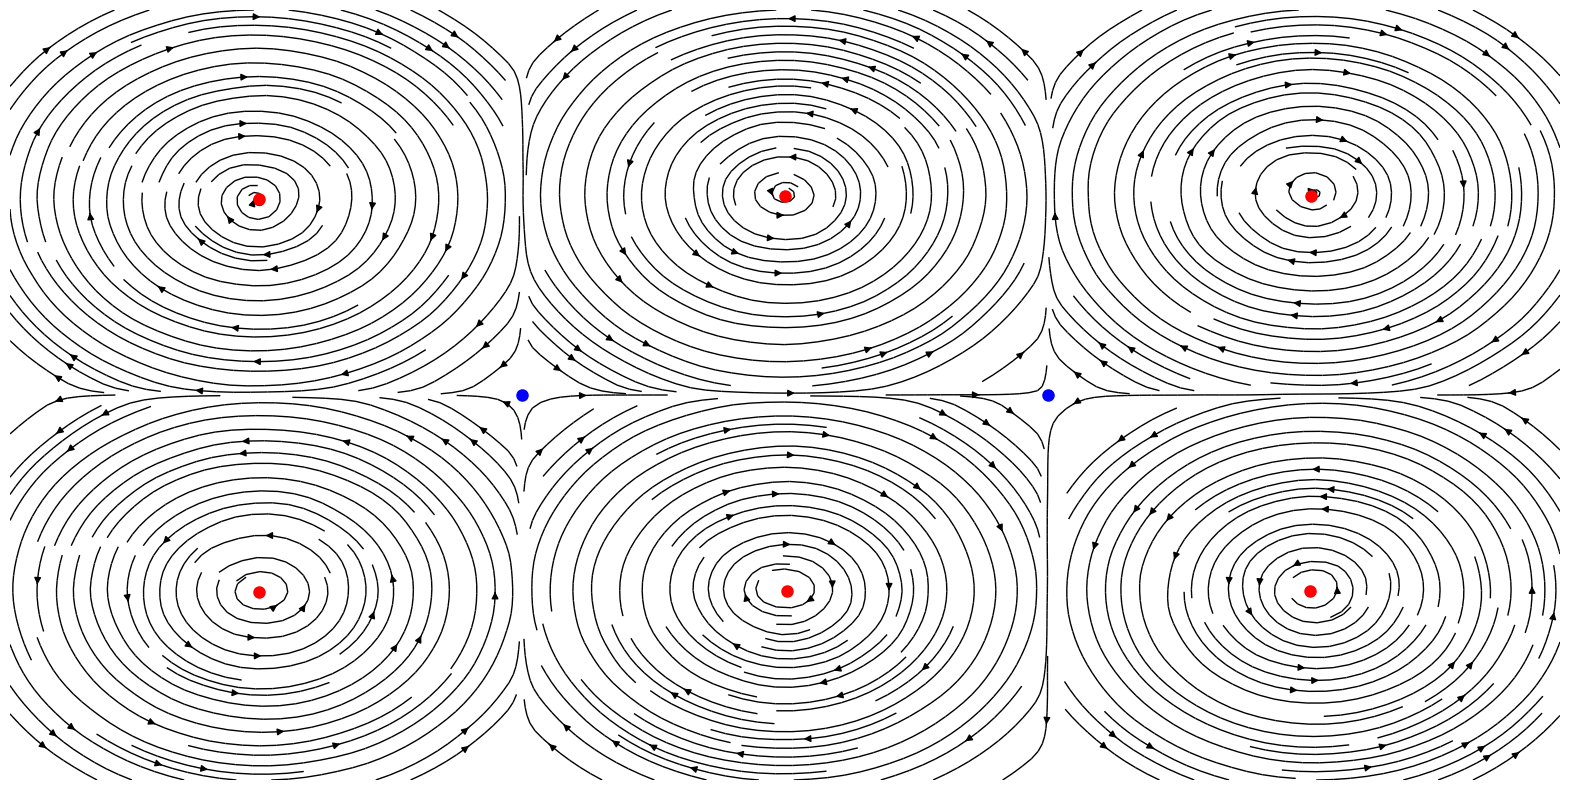

In [11]:
plot_vector_field_with_singularities(VF, centers)